# Задача 10. Graph Convolutional Network

- Найти графовый набор данных для решения задачи предсказания (классификация вершин, обнаружение сообществ и т.д.).
- Использовать несколько слоев `GCNConv` из библиотеки `PyG` для построения GCN модели.
- Обучить полученную модель, подобрать гиперпараметры (например, learning rate) на валидационной выборке, и оценить качество предсказания на тестовой выборке.
- (+5 баллов) Также представить самостоятельную реализацию слоя `GCNConv`, используя матричные операции. Повторить обучение с собственными слоями и сравнить результаты.

## Dataset

**PubMed Diabetes** – графовый датасет медицинских публикаций о диабете, где узлы представляют статьи (19,717 публикаций), связанные рёбрами цитирования, а каждая статья описывается 500 признаками на основе содержания.

**Классы**: Публикации разделены на 3 класса по типу диабетических исследований:
1. Diabetes Mellitus, Experimental (экспериментальные исследования)
2. Diabetes Mellitus Type 1 (диабет 1 типа)
3. Diabetes Mellitus Type 2 (диабет 2 типа)

**Цель задачи**: Классификация вершин – определение типа диабетических исследований по содержанию статьи и её связям с другими публикациями.

Loading PubMed Diabetes dataset...

=== DATASET INFORMATION ===
Dataset name: PubMed Diabetes
Number of nodes (papers): 19,717
Number of edges (citations): 88,648
Number of classes: 3
Number of features per node: 500
Training set size: 60
Validation set size: 500
Test set size: 1000

=== CLASS DISTRIBUTION ===
Class 1 (Diabetes Mellitus Type 1): 7,739 papers (39.3%)
Class 0 (Diabetes Mellitus, Experimental): 4,103 papers (20.8%)
Class 2 (Diabetes Mellitus Type 2): 7,875 papers (39.9%)

Performing PCA for feature visualization...


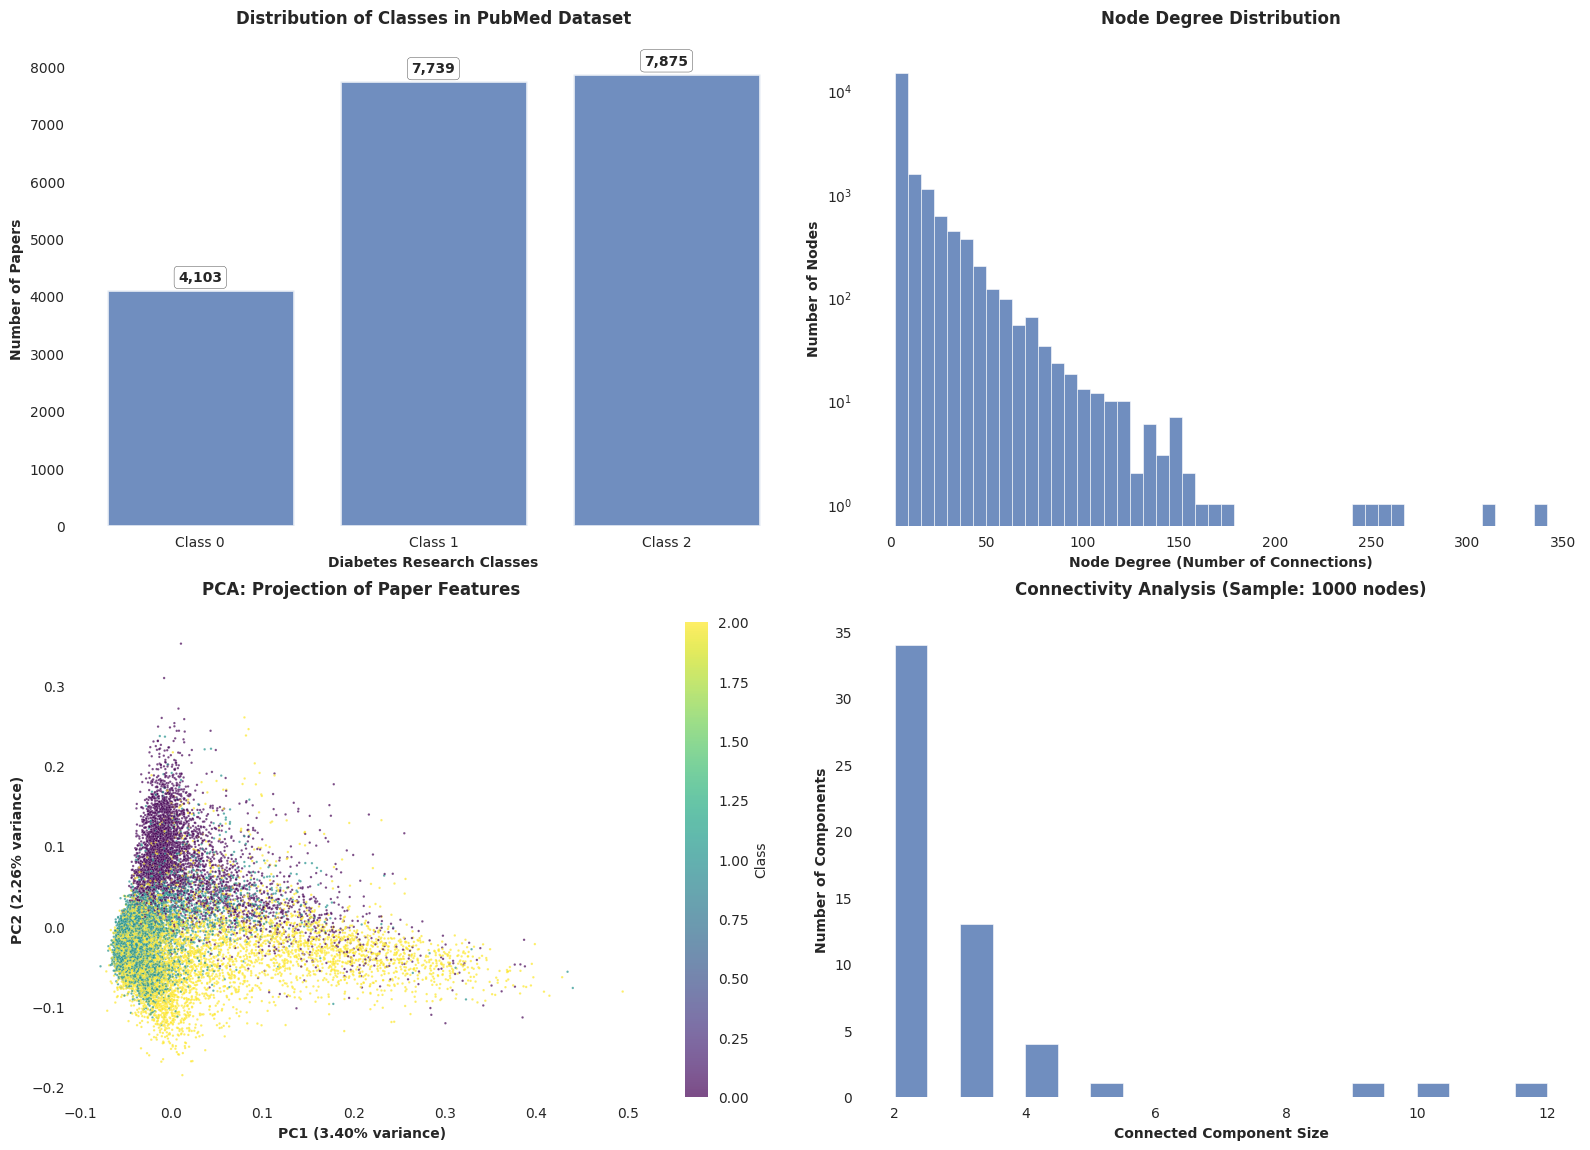

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from sklearn.decomposition import PCA
import networkx as nx
from collections import Counter

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Loading PubMed Diabetes dataset
print("Loading PubMed Diabetes dataset...")
dataset = Planetoid(root='./data/pubmed', name='PubMed')
data = dataset[0]

# Basic dataset information
print("\n=== DATASET INFORMATION ===")
print(f"Dataset name: PubMed Diabetes")
print(f"Number of nodes (papers): {data.num_nodes:,}")
print(f"Number of edges (citations): {data.num_edges:,}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Number of features per node: {dataset.num_node_features}")
print(f"Training set size: {data.train_mask.sum().item()}")
print(f"Validation set size: {data.val_mask.sum().item()}")
print(f"Test set size: {data.test_mask.sum().item()}")

# Class names
class_names = [
    'Diabetes Mellitus,\nExperimental',
    'Diabetes Mellitus\nType 1', 
    'Diabetes Mellitus\nType 2'
]

# Class distribution analysis
class_counts = Counter(data.y.numpy())
print(f"\n=== CLASS DISTRIBUTION ===")
for i, count in class_counts.items():
    print(f"Class {i} ({class_names[i].replace(chr(10), ' ')}): {count:,} papers ({count/data.num_nodes*100:.1f}%)")

# Create enhanced visualizations
fig = plt.figure(figsize=(16, 12))
fig.patch.set_facecolor('white')

# Plot 1: Class distribution
ax1 = plt.subplot(2, 2, 1)
class_labels = [class_names[i] for i in sorted(class_counts.keys())]
class_values = [class_counts[i] for i in sorted(class_counts.keys())]

bars = ax1.bar(range(len(class_values)), class_values, 
               alpha=0.8, edgecolor='white', linewidth=2)

ax1.set_xlabel('Diabetes Research Classes', fontweight='bold')
ax1.set_ylabel('Number of Papers', fontweight='bold')
ax1.set_title('Distribution of Classes in PubMed Dataset', fontweight='bold', pad=20)
ax1.set_xticks(range(len(class_labels)))
ax1.set_xticklabels([f'Class {i}' for i in range(len(class_labels))])

# Add value labels on bars
for bar, value in zip(bars, class_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{value:,}', ha='center', va='bottom', fontweight='bold', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Node degree distribution
ax2 = plt.subplot(2, 2, 2)
edge_index = data.edge_index
degrees = torch.zeros(data.num_nodes)
for edge in edge_index.t():
    degrees[edge[0]] += 1
    degrees[edge[1]] += 1

# Create histogram
n, bins, patches = ax2.hist(degrees.numpy(), bins=50, alpha=0.8, 
                           edgecolor='white', linewidth=0.5)

ax2.set_xlabel('Node Degree (Number of Connections)', fontweight='bold')
ax2.set_ylabel('Number of Nodes', fontweight='bold')
ax2.set_title('Node Degree Distribution', fontweight='bold', pad=20)
ax2.set_yscale('log')
ax2.grid(alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Plot 3: PCA visualization
ax3 = plt.subplot(2, 2, 3)
print("\nPerforming PCA for feature visualization...")
pca = PCA(n_components=2)
features_2d = pca.fit_transform(data.x.numpy())

# Create scatter plot
scatter = ax3.scatter(features_2d[:, 0], features_2d[:, 1], 
                     c=data.y.numpy(), cmap='viridis', alpha=0.7, s=3, 
                     edgecolors='white', linewidth=0.1)

ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontweight='bold')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontweight='bold')
ax3.set_title('PCA: Projection of Paper Features', fontweight='bold', pad=20)
plt.colorbar(scatter, ax=ax3, label='Class')
ax3.grid(alpha=0.3, linestyle='--')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Plot 4: Connectivity analysis
ax4 = plt.subplot(2, 2, 4)
# Create smaller subgraph for analysis
sample_nodes = np.random.choice(data.num_nodes, size=min(1000, data.num_nodes), replace=False)
sample_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
sample_mask[sample_nodes] = True

# Filter edges for subgraph
edge_mask = sample_mask[edge_index[0]] & sample_mask[edge_index[1]]
sample_edges = edge_index[:, edge_mask]

# Create NetworkX graph
G = nx.Graph()
for i in range(sample_edges.shape[1]):
    G.add_edge(sample_edges[0, i].item(), sample_edges[1, i].item())

# Connectivity component analysis
components = list(nx.connected_components(G))
component_sizes = [len(comp) for comp in components]

# Create histogram
n, bins, patches = ax4.hist(component_sizes, bins=20, alpha=0.8, 
                           edgecolor='white', linewidth=0.5)

ax4.set_xlabel('Connected Component Size', fontweight='bold')
ax4.set_ylabel('Number of Components', fontweight='bold')
ax4.set_title(f'Connectivity Analysis (Sample: {len(sample_nodes)} nodes)', fontweight='bold', pad=20)
ax4.grid(alpha=0.3, linestyle='--')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

## Custom GCN Layer Implementation

In [2]:
import torch.nn as nn
from torch_geometric.utils import add_self_loops, degree

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cpu')

class CustomGCNConv(nn.Module):
    """
    Custom implementation of Graph Convolutional Network layer
    Using sparse operations for efficiency
    """
    def __init__(self, input_features, output_features):
        super(CustomGCNConv, self).__init__()
        
        self.linear_transform = nn.Linear(input_features, output_features, bias=False)
        self.bias_param = nn.Parameter(torch.zeros(output_features))
        
        self._initialize_weights()

    def _initialize_weights(self):
        self.linear_transform.reset_parameters()
        nn.init.zeros_(self.bias_param)

    def forward(self, node_features, edge_connections):
        num_nodes = node_features.size(0)
        
        # Add self-loops
        edge_connections_with_loops, _ = add_self_loops(
            edge_connections, num_nodes=num_nodes
        )
        
        source_nodes, target_nodes = edge_connections_with_loops
        
        # Compute node degrees
        node_degrees = degree(source_nodes, num_nodes, dtype=node_features.dtype)
        degree_inv_sqrt = node_degrees.pow(-0.5)
        degree_inv_sqrt[torch.isinf(degree_inv_sqrt)] = 0.0
        
        # Edge normalization weights
        edge_weights = degree_inv_sqrt[source_nodes] * degree_inv_sqrt[target_nodes]
        
        # Create sparse normalized adjacency matrix
        sparse_adj_matrix = torch.sparse_coo_tensor(
            edge_connections_with_loops, 
            edge_weights, 
            size=(num_nodes, num_nodes),
            device=node_features.device,
            dtype=node_features.dtype
        )
        
        # Graph convolution: A_norm @ X @ W + bias
        aggregated_features = torch.sparse.mm(sparse_adj_matrix, node_features)
        transformed_features = self.linear_transform(aggregated_features)
        output = transformed_features + self.bias_param
        
        return output
    
    def extra_repr(self):
        return f'input_features={self.linear_transform.in_features}, output_features={self.linear_transform.out_features}'

## GCN Models

In [3]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class PyGGCN(torch.nn.Module):
    """GCN model using PyTorch Geometric layers"""
    def __init__(self, num_features, hidden_dim, num_classes, num_layers=2, dropout=0.5):
        super(PyGGCN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        # First layer
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(num_features, hidden_dim))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            
        # Output layer
        self.convs.append(GCNConv(hidden_dim, num_classes))
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            
        # Final layer without activation
        x = self.convs[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

class CustomGCN(torch.nn.Module):
    """GCN model using custom GCN layers"""
    def __init__(self, num_features, hidden_dim, num_classes, num_layers=2, dropout=0.5):
        super(CustomGCN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        # First layer
        self.convs = nn.ModuleList()
        self.convs.append(CustomGCNConv(num_features, hidden_dim))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(CustomGCNConv(hidden_dim, hidden_dim))
            
        # Output layer
        self.convs.append(CustomGCNConv(hidden_dim, num_classes))
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            
        # Final layer without activation
        x = self.convs[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

### Training and Evaluation Functions

In [4]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time

def train_model(model, data, optimizer, criterion):
    """Train the model for one epoch"""
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data, mask):
    """Evaluate the model on given mask"""
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        loss = F.nll_loss(out[mask], data.y[mask]).item()
    return acc, loss

def hyperparameter_search(model_class, data, param_grid, num_epochs=200):
    """Perform hyperparameter search"""
    best_params = None
    best_val_acc = 0
    results = []
    
    print(f"\nPerforming hyperparameter search for {model_class.__name__}...")
    
    for lr in param_grid['learning_rate']:
        for hidden_dim in param_grid['hidden_dim']:
            for dropout in param_grid['dropout']:
                for num_layers in param_grid['num_layers']:
                    print(f"Testing: lr={lr}, hidden={hidden_dim}, dropout={dropout}, layers={num_layers}")
                    
                    # Initialize model
                    model = model_class(
                        data.num_node_features, 
                        hidden_dim, 
                        dataset.num_classes,
                        num_layers=num_layers,
                        dropout=dropout
                    ).to(device)
                    
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
                    criterion = torch.nn.NLLLoss()
                    
                    # Train model
                    best_val_acc_epoch = 0
                    patience = 50
                    patience_counter = 0
                    
                    for epoch in range(num_epochs):
                        train_loss = train_model(model, data, optimizer, criterion)
                        val_acc, val_loss = evaluate_model(model, data, data.val_mask)
                        
                        if val_acc > best_val_acc_epoch:
                            best_val_acc_epoch = val_acc
                            patience_counter = 0
                        else:
                            patience_counter += 1
                            
                        if patience_counter >= patience:
                            break
                    
                    # Record results
                    params = {
                        'lr': lr, 
                        'hidden_dim': hidden_dim, 
                        'dropout': dropout,
                        'num_layers': num_layers,
                        'val_acc': best_val_acc_epoch
                    }
                    results.append(params)
                    
                    if best_val_acc_epoch > best_val_acc:
                        best_val_acc = best_val_acc_epoch
                        best_params = params.copy()
    
    return best_params, results

def train_final_model(model_class, data, best_params, num_epochs=500):
    """Train final model with best parameters"""
    print(f"\nTraining final {model_class.__name__} model with best parameters...")
    print(f"Best parameters: {best_params}")
    
    model = model_class(
        data.num_node_features,
        best_params['hidden_dim'],
        dataset.num_classes,
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=5e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=20)
    criterion = torch.nn.NLLLoss()
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0
    best_model_state = None
    patience = 100
    patience_counter = 0
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training
        train_loss = train_model(model, data, optimizer, criterion)
        
        # Validation
        val_acc, val_loss = evaluate_model(model, data, data.val_mask)
        
        # Learning rate scheduling
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_acc)

        # Check if learning rate was reduced
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < current_lr:
            print(f"Learning rate reduced from {current_lr:.6f} to {new_lr:.6f}")
        
        # Record metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if epoch % 50 == 0:
            print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    training_time = time.time() - start_time
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses, val_accuracies, training_time

## Hyperparameter Search

In [5]:
# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.001],
    'hidden_dim': [16, 32, 64],
    'dropout': [0.3, 0.5],
    'num_layers': [2, 3]
}

# Search for Custom GCN
custom_best_params, custom_results = hyperparameter_search(CustomGCN, data, param_grid, num_epochs=100)

# Search for PyG GCN
pyg_best_params, pyg_results = hyperparameter_search(PyGGCN, data, param_grid, num_epochs=100)


Performing hyperparameter search for CustomGCN...
Testing: lr=0.01, hidden=16, dropout=0.3, layers=2
Testing: lr=0.01, hidden=16, dropout=0.3, layers=3
Testing: lr=0.01, hidden=16, dropout=0.5, layers=2
Testing: lr=0.01, hidden=16, dropout=0.5, layers=3
Testing: lr=0.01, hidden=32, dropout=0.3, layers=2
Testing: lr=0.01, hidden=32, dropout=0.3, layers=3
Testing: lr=0.01, hidden=32, dropout=0.5, layers=2
Testing: lr=0.01, hidden=32, dropout=0.5, layers=3
Testing: lr=0.01, hidden=64, dropout=0.3, layers=2
Testing: lr=0.01, hidden=64, dropout=0.3, layers=3
Testing: lr=0.01, hidden=64, dropout=0.5, layers=2
Testing: lr=0.01, hidden=64, dropout=0.5, layers=3
Testing: lr=0.001, hidden=16, dropout=0.3, layers=2
Testing: lr=0.001, hidden=16, dropout=0.3, layers=3
Testing: lr=0.001, hidden=16, dropout=0.5, layers=2
Testing: lr=0.001, hidden=16, dropout=0.5, layers=3
Testing: lr=0.001, hidden=32, dropout=0.3, layers=2
Testing: lr=0.001, hidden=32, dropout=0.3, layers=3
Testing: lr=0.001, hidden

## Training and Evaluation

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train final models
pyg_model, pyg_train_losses, pyg_val_losses, pyg_val_accs, pyg_time = train_final_model(
    PyGGCN, data, pyg_best_params, num_epochs=500)

custom_model, custom_train_losses, custom_val_losses, custom_val_accs, custom_time = train_final_model(
    CustomGCN, data, custom_best_params, num_epochs=500)

# Evaluate both models
pyg_test_acc, pyg_test_loss = evaluate_model(pyg_model, data, data.test_mask)
custom_test_acc, custom_test_loss = evaluate_model(custom_model, data, data.test_mask)

print(f"\n=== FINAL RESULTS ===")
print(f"PyTorch Geometric GCN:")
print(f"  Best params: {pyg_best_params}")
print(f"  Test Accuracy: {pyg_test_acc:.4f}")
print(f"  Test Loss: {pyg_test_loss:.4f}")
print(f"  Training Time: {pyg_time:.2f}s")

print(f"\nCustom GCN:")
print(f"  Best params: {custom_best_params}")
print(f"  Test Accuracy: {custom_test_acc:.4f}")
print(f"  Test Loss: {custom_test_loss:.4f}")
print(f"  Training Time: {custom_time:.2f}s")

# Detailed evaluation
def detailed_evaluation(model, data, model_name):
    """Perform detailed evaluation including classification report"""
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.max(1)[1]
        
        # Test set predictions
        test_pred = pred[data.test_mask].cpu().numpy()
        test_true = data.y[data.test_mask].cpu().numpy()
        
        print(f"\n=== {model_name} Detailed Evaluation ===")
        print(f"Test Accuracy: {accuracy_score(test_true, test_pred):.4f}")
        print("\nClassification Report:")
        print(classification_report(test_true, test_pred, 
                                  target_names=['Class 0', 'Class 1', 'Class 2']))
        
        return test_pred, test_true

pyg_pred, test_true = detailed_evaluation(pyg_model, data, "PyTorch Geometric GCN")
custom_pred, _ = detailed_evaluation(custom_model, data, "Custom GCN")


Training final PyGGCN model with best parameters...
Best parameters: {'lr': 0.01, 'hidden_dim': 16, 'dropout': 0.5, 'num_layers': 2, 'val_acc': 0.8}
Epoch 000, Train Loss: 1.0962, Val Loss: 1.0874, Val Acc: 0.6180
Epoch 050, Train Loss: 0.2295, Val Loss: 0.5932, Val Acc: 0.7800
Learning rate reduced from 0.010000 to 0.005000
Learning rate reduced from 0.005000 to 0.002500
Epoch 100, Train Loss: 0.1915, Val Loss: 0.5615, Val Acc: 0.7900
Learning rate reduced from 0.002500 to 0.001250
Epoch 150, Train Loss: 0.1087, Val Loss: 0.5563, Val Acc: 0.7940
Learning rate reduced from 0.001250 to 0.000625
Learning rate reduced from 0.000625 to 0.000313
Epoch 200, Train Loss: 0.1050, Val Loss: 0.5579, Val Acc: 0.7880
Learning rate reduced from 0.000313 to 0.000156
Early stopping at epoch 217

Training final CustomGCN model with best parameters...
Best parameters: {'lr': 0.01, 'hidden_dim': 32, 'dropout': 0.5, 'num_layers': 2, 'val_acc': 0.8}
Epoch 000, Train Loss: 1.0984, Val Loss: 1.0956, Val Acc

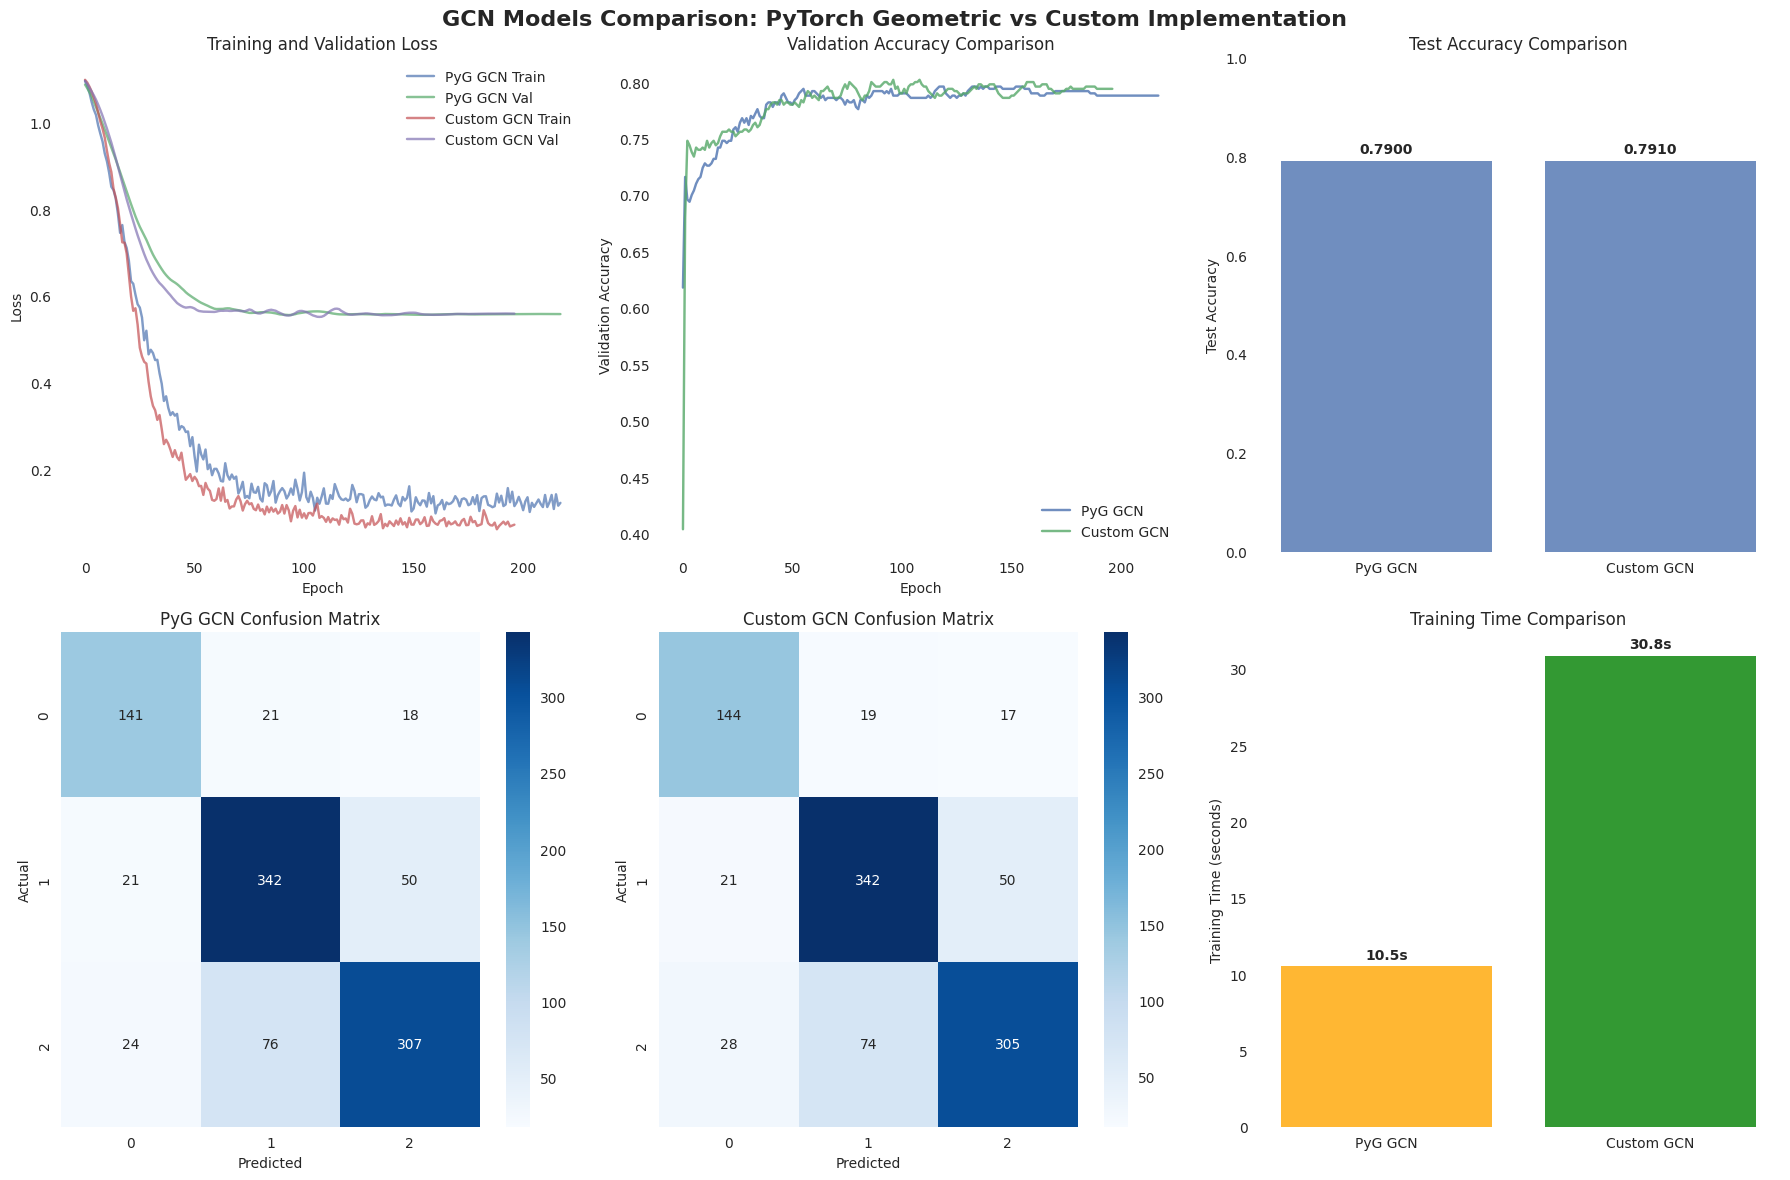


=== SUMMARY COMPARISON ===
Metric               PyG GCN      Custom GCN   Difference  
------------------------------------------------------------
Test Accuracy        0.7900       0.7910       0.0010      
Test Loss            0.5696       0.5707       0.0011      
Training Time        10.5         30.8         20.3        
Best LR              0.01         0.01         -           
Best Hidden Dim      16           32           -           


In [7]:
import seaborn as sns

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('GCN Models Comparison: PyTorch Geometric vs Custom Implementation', 
             fontsize=16, fontweight='bold')

# Training curves
ax1 = axes[0, 0]
epochs_pyg = range(len(pyg_train_losses))
epochs_custom = range(len(custom_train_losses))

ax1.plot(epochs_pyg, pyg_train_losses, label='PyG GCN Train', alpha=0.7)
ax1.plot(epochs_pyg, pyg_val_losses, label='PyG GCN Val', alpha=0.7)
ax1.plot(epochs_custom, custom_train_losses, label='Custom GCN Train', alpha=0.7)
ax1.plot(epochs_custom, custom_val_losses, label='Custom GCN Val', alpha=0.7)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation accuracy
ax2 = axes[0, 1]
ax2.plot(epochs_pyg, pyg_val_accs, label='PyG GCN', alpha=0.8)
ax2.plot(epochs_custom, custom_val_accs, label='Custom GCN', alpha=0.8)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Accuracy')
ax2.set_title('Validation Accuracy Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Performance comparison
ax3 = axes[0, 2]
models = ['PyG GCN', 'Custom GCN']
test_accs = [pyg_test_acc, custom_test_acc]
training_times = [pyg_time, custom_time]

bars = ax3.bar(models, test_accs, alpha=0.8)
ax3.set_ylabel('Test Accuracy')
ax3.set_title('Test Accuracy Comparison')
ax3.set_ylim(0, 1)

# Add values on bars
for bar, acc in zip(bars, test_accs):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Confusion matrices
def plot_confusion_matrix(true_labels, pred_labels, title, ax):
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plot_confusion_matrix(test_true, pyg_pred, 'PyG GCN Confusion Matrix', axes[1, 0])
plot_confusion_matrix(test_true, custom_pred, 'Custom GCN Confusion Matrix', axes[1, 1])

# Training time comparison
ax6 = axes[1, 2]
bars = ax6.bar(models, training_times, alpha=0.8, color=['orange', 'green'])
ax6.set_ylabel('Training Time (seconds)')
ax6.set_title('Training Time Comparison')

# Add values on bars
for bar, time_val in zip(bars, training_times):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.01,
             f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary table
print(f"\n=== SUMMARY COMPARISON ===")
print(f"{'Metric':<20} {'PyG GCN':<12} {'Custom GCN':<12} {'Difference':<12}")
print("-" * 60)
print(f"{'Test Accuracy':<20} {pyg_test_acc:<12.4f} {custom_test_acc:<12.4f} {abs(pyg_test_acc-custom_test_acc):<12.4f}")
print(f"{'Test Loss':<20} {pyg_test_loss:<12.4f} {custom_test_loss:<12.4f} {abs(pyg_test_loss-custom_test_loss):<12.4f}")
print(f"{'Training Time':<20} {pyg_time:<12.1f} {custom_time:<12.1f} {abs(pyg_time-custom_time):<12.1f}")
print(f"{'Best LR':<20} {pyg_best_params['lr']:<12} {custom_best_params['lr']:<12} {'-':<12}")
print(f"{'Best Hidden Dim':<20} {pyg_best_params['hidden_dim']:<12} {custom_best_params['hidden_dim']:<12} {'-':<12}")